In [ ]:
!pip install datasets
!pip install transformers[torch]
!pip install evaluate

In [ ]:
import pandas as pd
import ast
import numpy as np
import string
import random
import torch
import evaluate
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from torch.nn import BCEWithLogitsLoss, Sigmoid
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer

In [ ]:
df_train = pd.read_csv("ReXErr-report-level_train.csv")
df_train = df_train.dropna()
df_train = df_train.sample(frac=0.1)
df_val = pd.read_csv("ReXErr-report-level_val.csv")
df_val = df_val.dropna()

In [ ]:
df_train['error_report'] = df_train['error_report'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()
df_train['original_report'] = df_train['original_report'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()
df_train["text"] = "[CLS] " + df_train["error_report"] + " [SEP] " + df_train["original_report"] + " [SEP]"

df_val['error_report'] = df_val['error_report'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()
df_val['original_report'] = df_val['original_report'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()
df_val["text"] = "[CLS] " + df_val["error_report"] + " [SEP] " + df_val["original_report"] + " [SEP]"

In [ ]:
df_train['errors_sampled'] = df_train['errors_sampled'].apply(ast.literal_eval)
df_val['errors_sampled'] = df_val['errors_sampled'].apply(ast.literal_eval)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df_train['errors_sampled'])
df_train['labels'] = labels.astype(np.float32).tolist()

labels = mlb.fit_transform(df_val['errors_sampled'])
df_val['labels'] = labels.astype(np.float32).tolist()

labels_name = mlb.classes_

In [ ]:
df_test = pd.read_csv("ReXErr-report-level_test.csv")
df_test = df_test.dropna()

df_test['error_report'] = df_test['error_report'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()
df_test['original_report'] = df_test['original_report'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()
df_test["text"] = "[CLS] " + df_test["error_report"] + " [SEP] " + df_test["original_report"] + " [SEP]"

df_test['errors_sampled'] = df_test['errors_sampled'].apply(ast.literal_eval)
labels = mlb.fit_transform(df_test['errors_sampled'])
df_test['labels'] = labels.astype(np.float32).tolist()

# BioBert

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
dataset_train = Dataset.from_pandas(df_train[["text", "labels"]])
dataset_val = Dataset.from_pandas(df_val[["text", "labels"]])

def preprocess(doc):
  return tokenizer(doc['text'], max_length = 512, truncation=True)

tokenized_dataset_train = dataset_train.map(preprocess, batched=True)
tokenized_dataset_val = dataset_val.map(preprocess, batched=True)

Map:   0%|          | 0/20140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1635 [00:00<?, ? examples/s]

In [ ]:
model_name = "dmis-lab/biobert-base-cased-v1.2"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(mlb.classes_), problem_type="multi_label_classification")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
task = "error_classification"

training_args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid = Sigmoid()
    probs = sigmoid(torch.tensor(logits))
    preds = (probs > 0.5).int().numpy()
    labels = labels.astype(int)

    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="micro"),
        "recall": recall_score(labels, preds, average="micro"),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1615276644.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision,Recall
1,0.336800,0.210246,0.848189,0.844033,0.885537,0.813863
2,0.190500,0.155313,0.885616,0.880731,0.908098,0.864220
3,0.144900,0.145235,0.890981,0.889412,0.915109,0.868094
4,0.120500,0.134723,0.902924,0.900784,0.922014,0.884608
5,0.102200,0.138642,0.903199,0.903175,0.917543,0.889297
6,0.088300,0.145136,0.901131,0.901007,0.908601,0.893782
7,0.076500,0.141325,0.905637,0.905368,0.917381,0.894190
8,0.066700,0.146820,0.903000,0.902402,0.913261,0.892966
9,0.059300,0.151749,0.903664,0.904259,0.912492,0.895005
10,0.053200,0.152104,0.902934,0.904058,0.911850,0.894190


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

TrainOutput(global_step=25180, training_loss=0.12387321054035941, metrics={'train_runtime': 3052.5075, 'train_samples_per_second': 65.979, 'train_steps_per_second': 8.249, 'total_flos': 3.55703197812624e+16, 'train_loss': 0.12387321054035941, 'epoch': 10.0})

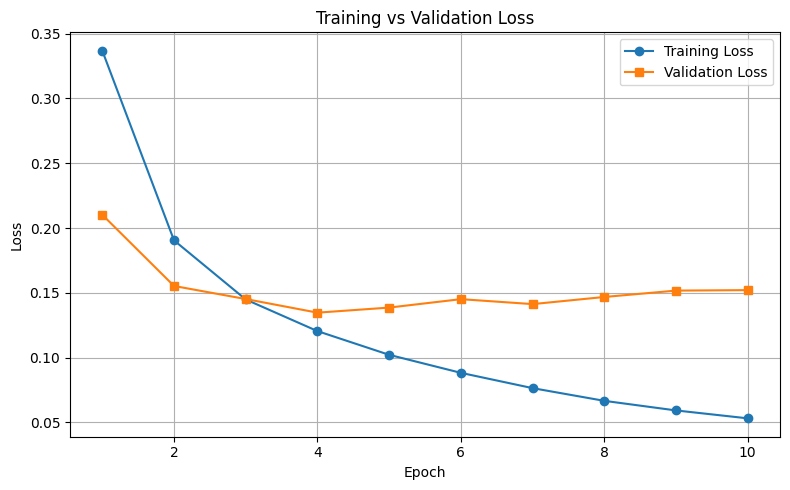

In [ ]:
log_history = trainer.state.log_history

train_loss = []
eval_loss = []
epochs = []

for entry in log_history:
    if 'loss' in entry and 'epoch' in entry:
        train_loss.append(entry['loss'])
        epochs.append(entry['epoch'])
    elif 'eval_loss' in entry and 'epoch' in entry:
        eval_loss.append(entry['eval_loss'])

# In case eval logs are fewer (e.g., logging only every epoch)
min_len = min(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_len]
eval_loss = eval_loss[:min_len]
epochs = epochs[:min_len]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dataset_test = Dataset.from_pandas(df_test[["text", "labels"]])

tokenized_dataset_test = dataset_test.map(preprocess, batched=True)

Map:   0%|          | 0/2708 [00:00<?, ? examples/s]

In [ ]:
metrics = trainer.evaluate(tokenized_dataset_test)

In [ ]:
metrics

{'eval_loss': 0.14564034342765808,
 'eval_f1_micro': 0.8890426468738206,
 'eval_f1_macro': 0.8875827103584145,
 'eval_precision': 0.9090558271160278,
 'eval_recall': 0.8698916789758739,
 'eval_runtime': 15.3813,
 'eval_samples_per_second': 176.058,
 'eval_steps_per_second': 22.04,
 'epoch': 10.0}

In [ ]:
predictions_output = trainer.predict(tokenized_dataset_test)
logits = predictions_output.predictions
sigmoid = Sigmoid()
probs = sigmoid(torch.tensor(logits))
preds = (probs > 0.5).int().numpy()

In [ ]:
predictions_output_val = trainer.predict(tokenized_dataset_val)
logits_val = predictions_output_val.predictions
sigmoid = Sigmoid()
probs_val = sigmoid(torch.tensor(logits_val))

In [ ]:
loss = hamming_loss(tokenized_dataset_test['labels'], preds)

In [ ]:
loss

0.05428360413589365

In [ ]:
true_labels_np = np.array(tokenized_dataset_test['labels'])
false_negatives = np.logical_and(true_labels_np == 1, preds == 0)
false_positives = np.logical_and(true_labels_np == 0, preds == 1)

fn_counts = np.sum(false_negatives, axis=0)
fp_counts = np.sum(false_positives, axis=0)

total_errors = fn_counts + fp_counts

for i in np.argsort(-total_errors):
    print(f"{labels_name[i]}: {total_errors[i]} errors (FN: {fn_counts[i]}, FP: {fp_counts[i]})")

Change to homophone: 275 errors (FN: 197, FP: 78)
Add contradiction: 227 errors (FN: 143, FP: 84)
Add repetitions: 206 errors (FN: 89, FP: 117)
False negation: 193 errors (FN: 129, FP: 64)
False prediction: 187 errors (FN: 116, FP: 71)
Change position of device: 149 errors (FN: 56, FP: 93)
Add typo: 123 errors (FN: 72, FP: 51)
Change location: 113 errors (FN: 71, FP: 42)
Change severity: 96 errors (FN: 50, FP: 46)
Add medical device: 90 errors (FN: 58, FP: 32)
Change name of device: 88 errors (FN: 64, FP: 24)
Change measurement: 17 errors (FN: 12, FP: 5)


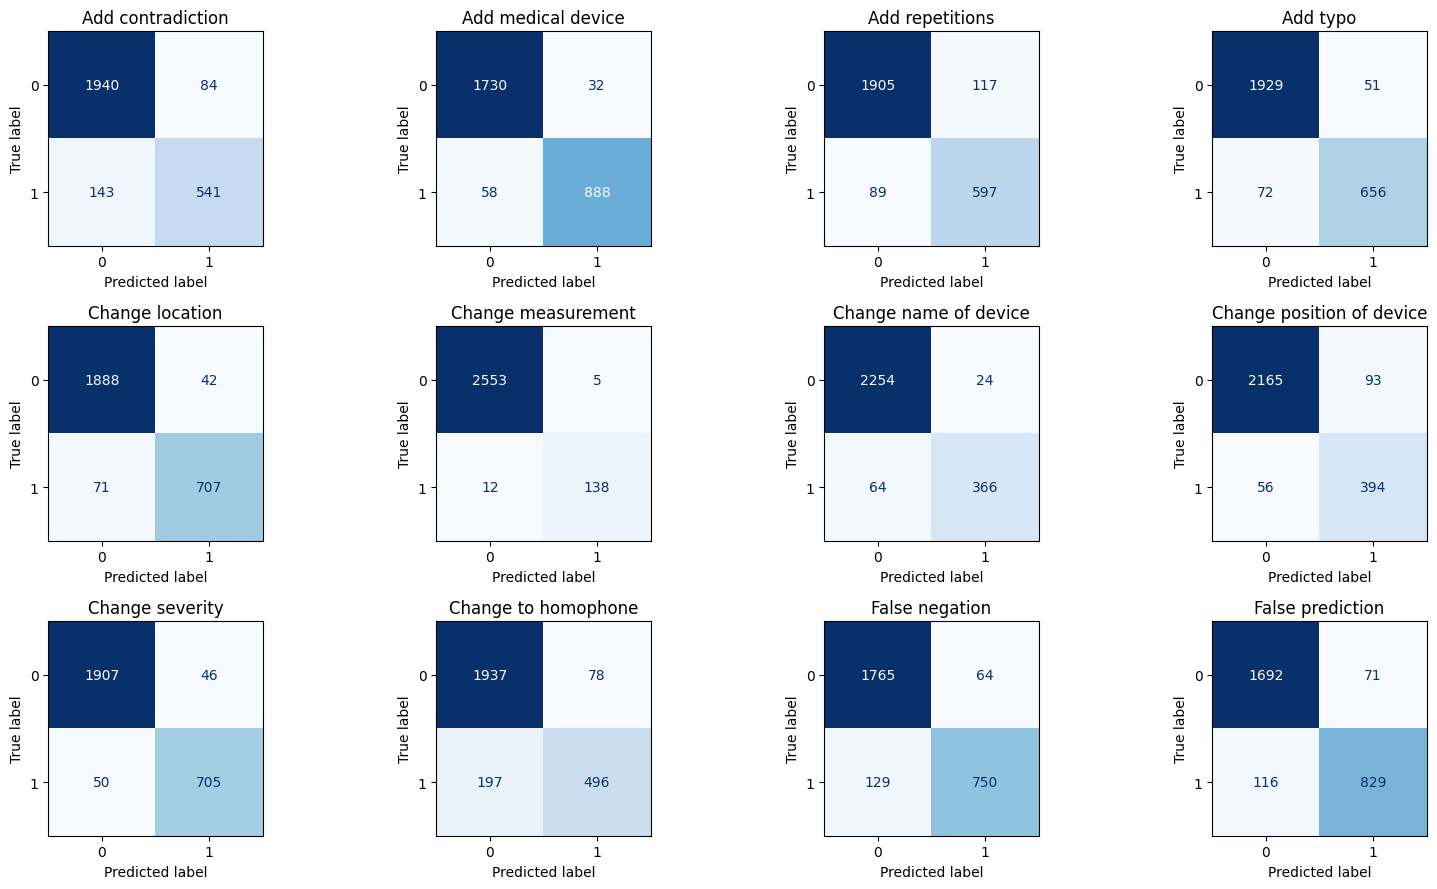

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm_all = multilabel_confusion_matrix(true_labels_np, preds)

n_rows = 3
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(cm_all, labels_name)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"0", "1"])
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

# Bio_ClinicalBERT

In [ ]:
tokenizer_bcl = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
dataset_train_bcl = Dataset.from_pandas(df_train[["text", "labels"]])
dataset_val_bcl = Dataset.from_pandas(df_val[["text", "labels"]])

def preprocess_bcl(doc):
  return tokenizer_bcl(doc['text'], max_length = 512, truncation=True)

tokenized_dataset_train_bcl = dataset_train_bcl.map(preprocess_bcl, batched=True)
tokenized_dataset_val_bcl = dataset_val_bcl.map(preprocess_bcl, batched=True)

Map:   0%|          | 0/20140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1635 [00:00<?, ? examples/s]

In [ ]:
model_name_bcl = "emilyalsentzer/Bio_ClinicalBERT"
model_bcl = AutoModelForSequenceClassification.from_pretrained(model_name_bcl, num_labels=len(mlb.classes_), problem_type="multi_label_classification")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
task_bcl = "error_classification_bcl"

training_args_bcl = TrainingArguments(
    f"{model_name_bcl}-finetuned-{task_bcl}",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics_bcl(eval_pred):
    logits, labels = eval_pred
    sigmoid = Sigmoid()
    probs = sigmoid(torch.tensor(logits))
    preds = (probs > 0.5).int().numpy()
    labels = labels.astype(int)

    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="micro"),
        "recall": recall_score(labels, preds, average="micro"),
    }

trainer_bcl = Trainer(
    model=model_bcl,
    args=training_args_bcl,
    train_dataset=tokenized_dataset_train_bcl,
    eval_dataset=tokenized_dataset_val_bcl,
    tokenizer=tokenizer_bcl,
    compute_metrics=compute_metrics_bcl
)

/tmp/ipython-input-3317208231.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bcl = Trainer(


In [ ]:
trainer_bcl.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision,Recall
1,0.386900,0.256504,0.769586,0.724354,0.888237,0.678899
2,0.221400,0.179195,0.861756,0.855388,0.906025,0.821611
3,0.161900,0.149955,0.884514,0.881965,0.919859,0.851784
4,0.130700,0.139864,0.895886,0.895033,0.923210,0.870133
5,0.110600,0.136600,0.900259,0.897362,0.916913,0.884200
6,0.095900,0.141286,0.899637,0.897201,0.914316,0.885423


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision,Recall
1,0.386900,0.256504,0.769586,0.724354,0.888237,0.678899
2,0.221400,0.179195,0.861756,0.855388,0.906025,0.821611
3,0.161900,0.149955,0.884514,0.881965,0.919859,0.851784
4,0.130700,0.139864,0.895886,0.895033,0.923210,0.870133
5,0.110600,0.136600,0.900259,0.897362,0.916913,0.884200
6,0.095900,0.141286,0.899637,0.897201,0.914316,0.885423
7,0.083300,0.139416,0.901464,0.898523,0.918536,0.885015
8,0.073700,0.141182,0.900361,0.897851,0.912134,0.888889
9,0.067000,0.145664,0.899453,0.896793,0.910058,0.889093
10,0.062000,0.144622,0.901467,0.899946,0.913544,0.889704


TrainOutput(global_step=25180, training_loss=0.13934972034360418, metrics={'train_runtime': 3045.4407, 'train_samples_per_second': 66.132, 'train_steps_per_second': 8.268, 'total_flos': 3.55703197812624e+16, 'train_loss': 0.13934972034360418, 'epoch': 10.0})

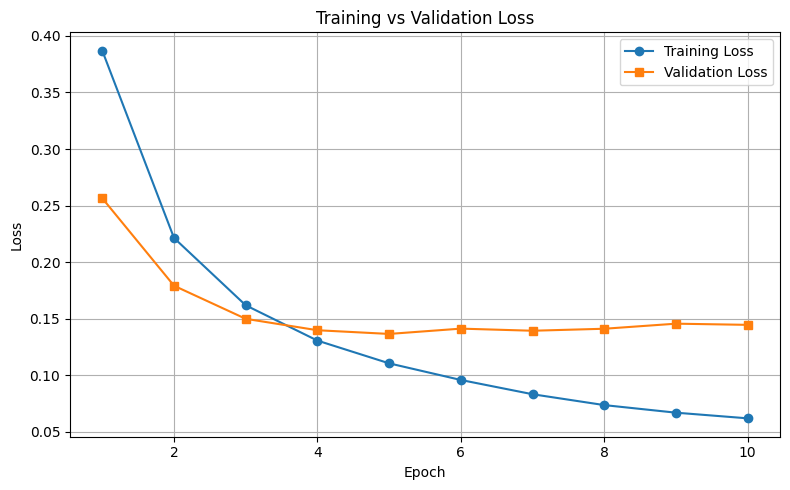

In [ ]:
log_history = trainer_bcl.state.log_history

train_loss = []
eval_loss = []
epochs = []

for entry in log_history:
    if 'loss' in entry and 'epoch' in entry:
        train_loss.append(entry['loss'])
        epochs.append(entry['epoch'])
    elif 'eval_loss' in entry and 'epoch' in entry:
        eval_loss.append(entry['eval_loss'])

# In case eval logs are fewer (e.g., logging only every epoch)
min_len = min(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_len]
eval_loss = eval_loss[:min_len]
epochs = epochs[:min_len]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dataset_test_bcl = Dataset.from_pandas(df_test[["text", "labels"]])

tokenized_dataset_test_bcl = dataset_test_bcl.map(preprocess_bcl, batched=True)

Map:   0%|          | 0/2708 [00:00<?, ? examples/s]

In [ ]:
metrics_bcl = trainer_bcl.evaluate(tokenized_dataset_test_bcl)

In [ ]:
metrics_bcl

{'eval_loss': 0.14442874491214752,
 'eval_f1_micro': 0.8892385147891756,
 'eval_f1_macro': 0.8851244180496111,
 'eval_precision': 0.9097347411795004,
 'eval_recall': 0.869645494830133,
 'eval_runtime': 15.3193,
 'eval_samples_per_second': 176.77,
 'eval_steps_per_second': 22.129,
 'epoch': 10.0}

In [ ]:
predictions_output_bcl_val = trainer_bcl.predict(tokenized_dataset_val_bcl)
logits_bcl_val = predictions_output_bcl_val.predictions

sigmoid_bcl = Sigmoid()
probs_bcl_val = sigmoid_bcl(torch.tensor(logits_bcl_val))

In [ ]:
predictions_output_bcl = trainer_bcl.predict(tokenized_dataset_test_bcl)
logits_bcl = predictions_output_bcl.predictions
sigmoid_bcl = Sigmoid()
probs_bcl = sigmoid_bcl(torch.tensor(logits_bcl))
preds_bcl = (probs_bcl > 0.5).int().numpy()

In [ ]:
loss_bcl = hamming_loss(tokenized_dataset_test_bcl['labels'], preds_bcl)

In [ ]:
loss_bcl

0.05416051206302314

In [ ]:
true_labels_np_bcl = np.array(tokenized_dataset_test_bcl['labels'])
false_negatives_bcl = np.logical_and(true_labels_np_bcl == 1, preds_bcl == 0)
false_positives_bcl = np.logical_and(true_labels_np_bcl == 0, preds_bcl == 1)

fn_counts_bcl = np.sum(false_negatives_bcl, axis=0)
fp_counts_bcl = np.sum(false_positives_bcl, axis=0)

total_errors_bcl = fn_counts_bcl + fp_counts_bcl

for i in np.argsort(-total_errors_bcl):
    print(f"{labels_name[i]}: {total_errors_bcl[i]} errors (FN: {fn_counts_bcl[i]}, FP: {fp_counts_bcl[i]})")

Change to homophone: 287 errors (FN: 171, FP: 116)
Add contradiction: 226 errors (FN: 145, FP: 81)
Add repetitions: 204 errors (FN: 128, FP: 76)
False prediction: 195 errors (FN: 124, FP: 71)
False negation: 176 errors (FN: 82, FP: 94)
Change position of device: 141 errors (FN: 76, FP: 65)
Add typo: 120 errors (FN: 76, FP: 44)
Change location: 110 errors (FN: 52, FP: 58)
Change severity: 92 errors (FN: 58, FP: 34)
Add medical device: 91 errors (FN: 72, FP: 19)
Change name of device: 89 errors (FN: 59, FP: 30)
Change measurement: 29 errors (FN: 16, FP: 13)


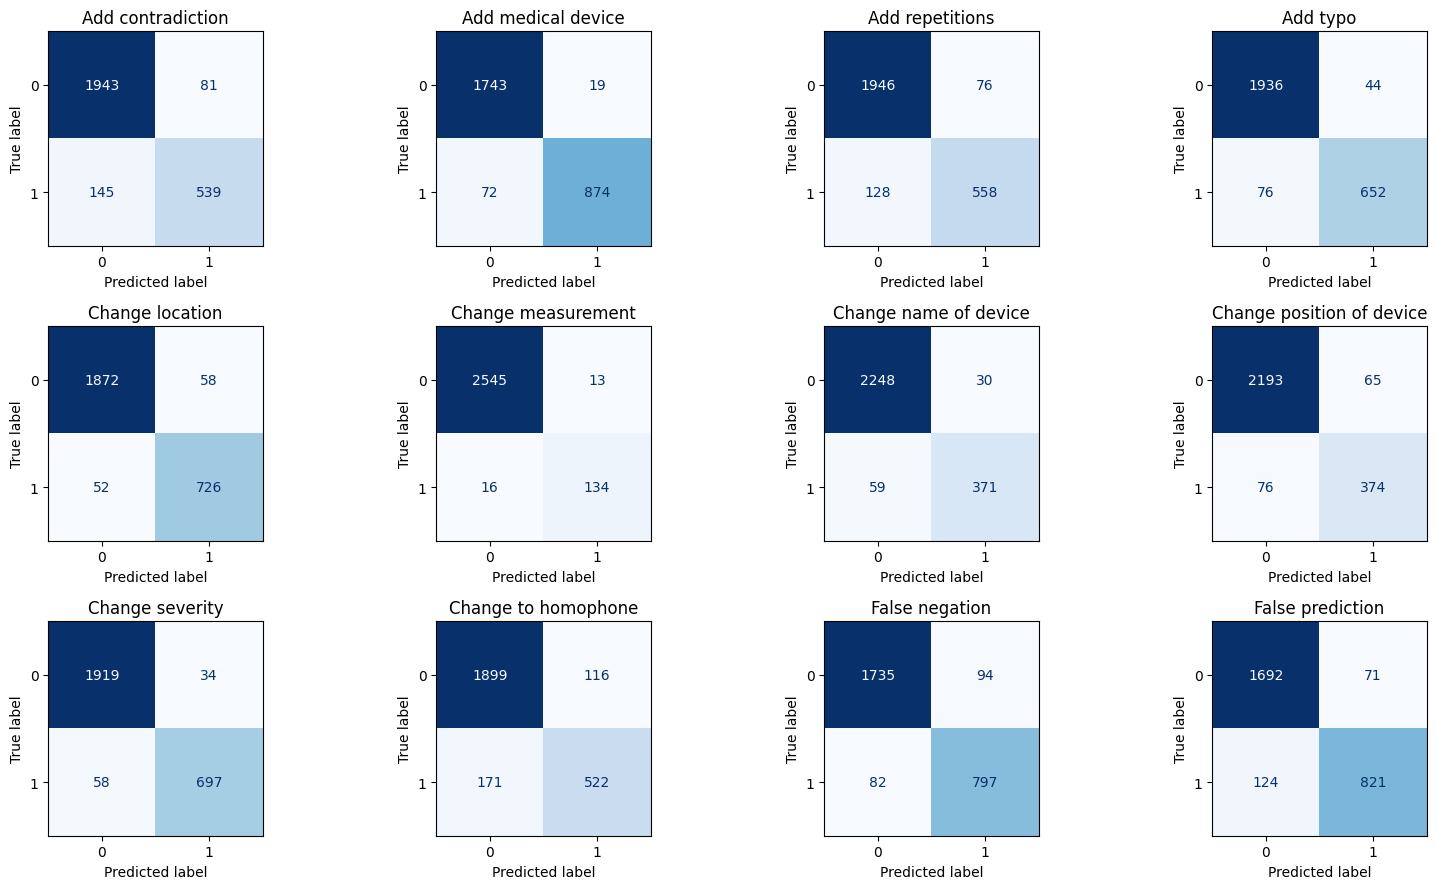

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm_all_bcl = multilabel_confusion_matrix(true_labels_np_bcl, preds_bcl)

n_rows = 3
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(cm_all_bcl, labels_name)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"0", "1"])
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

# Bert

In [ ]:
tokenizer_cl = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
dataset_train_cl = Dataset.from_pandas(df_train[["text", "labels"]])
dataset_val_cl = Dataset.from_pandas(df_val[["text", "labels"]])

def preprocess_cl(doc):
  return tokenizer_cl(doc['text'], max_length = 512, truncation=True)

tokenized_dataset_train_cl = dataset_train_cl.map(preprocess_cl, batched=True)
tokenized_dataset_val_cl = dataset_val_cl.map(preprocess_cl, batched=True)

Map:   0%|          | 0/20140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1635 [00:00<?, ? examples/s]

In [ ]:
model_name_cl = "bert-base-uncased"
model_cl = AutoModelForSequenceClassification.from_pretrained(model_name_cl, num_labels=len(mlb.classes_), problem_type="multi_label_classification")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
task_cl = "error_classification_cl"

training_args_cl = TrainingArguments(
    f"{model_name_cl}-finetuned-{task_cl}",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics_cl(eval_pred):
    logits, labels = eval_pred
    sigmoid = Sigmoid()
    probs = sigmoid(torch.tensor(logits))
    preds = (probs > 0.5).int().numpy()
    labels = labels.astype(int)

    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="micro"),
        "recall": recall_score(labels, preds, average="micro"),
    }

trainer_cl = Trainer(
    model=model_cl,
    args=training_args_cl,
    train_dataset=tokenized_dataset_train_cl,
    eval_dataset=tokenized_dataset_val_cl,
    tokenizer=tokenizer_cl,
    compute_metrics=compute_metrics_cl
)

In [ ]:
trainer_cl.train()

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision,Recall
1,0.376300,0.241024,0.818202,0.811109,0.885172,0.760652
2,0.212500,0.171775,0.874763,0.869211,0.905697,0.845872
3,0.156800,0.152587,0.887006,0.883431,0.911025,0.864220
4,0.129400,0.146669,0.887823,0.884835,0.908470,0.868094


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision,Recall
1,0.376300,0.241024,0.818202,0.811109,0.885172,0.760652
2,0.212500,0.171775,0.874763,0.869211,0.905697,0.845872
3,0.156800,0.152587,0.887006,0.883431,0.911025,0.864220
4,0.129400,0.146669,0.887823,0.884835,0.908470,0.868094
5,0.110100,0.142060,0.892107,0.889125,0.905502,0.879103
6,0.094300,0.142920,0.895079,0.894184,0.906015,0.884404
7,0.081700,0.144128,0.899505,0.896934,0.910591,0.888685
8,0.071000,0.146276,0.898897,0.897796,0.908920,0.889093
9,0.063400,0.154042,0.897135,0.895716,0.907234,0.887258
10,0.057600,0.153229,0.896616,0.895422,0.904900,0.888481


TrainOutput(global_step=25180, training_loss=0.13530843672627396, metrics={'train_runtime': 3012.7522, 'train_samples_per_second': 66.849, 'train_steps_per_second': 8.358, 'total_flos': 3.507835249548288e+16, 'train_loss': 0.13530843672627396, 'epoch': 10.0})

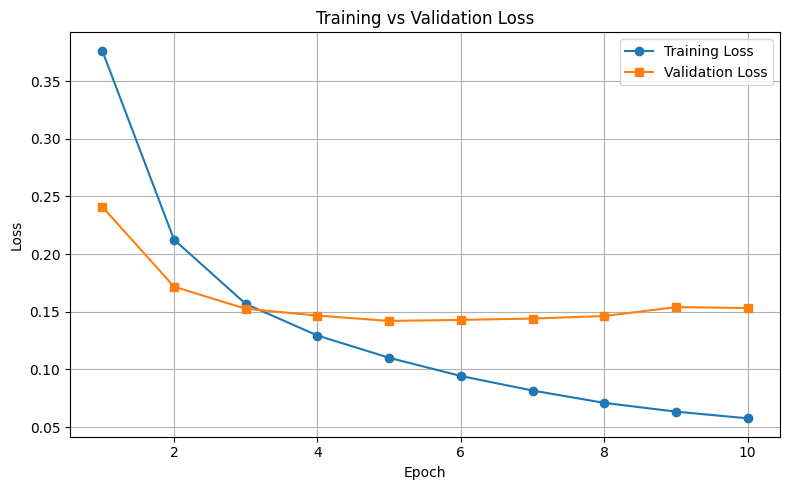

In [ ]:
log_history = trainer_cl.state.log_history

train_loss = []
eval_loss = []
epochs = []

for entry in log_history:
    if 'loss' in entry and 'epoch' in entry:
        train_loss.append(entry['loss'])
        epochs.append(entry['epoch'])
    elif 'eval_loss' in entry and 'epoch' in entry:
        eval_loss.append(entry['eval_loss'])

# In case eval logs are fewer (e.g., logging only every epoch)
min_len = min(len(train_loss), len(eval_loss))
train_loss = train_loss[:min_len]
eval_loss = eval_loss[:min_len]
epochs = epochs[:min_len]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dataset_test_cl = Dataset.from_pandas(df_test[["text", "labels"]])

tokenized_dataset_test_cl = dataset_test_cl.map(preprocess_cl, batched=True)

Map:   0%|          | 0/2708 [00:00<?, ? examples/s]

In [ ]:
metrics_cl = trainer_cl.evaluate(tokenized_dataset_test_cl)

In [ ]:
metrics_cl

{'eval_loss': 0.15033340454101562,
 'eval_f1_micro': 0.8867285499247366,
 'eval_f1_macro': 0.880523835627426,
 'eval_precision': 0.9039641943734016,
 'eval_recall': 0.870137863121615,
 'eval_runtime': 15.0573,
 'eval_samples_per_second': 179.846,
 'eval_steps_per_second': 22.514,
 'epoch': 10.0}

In [ ]:
predictions_output_cl = trainer_cl.predict(tokenized_dataset_test_cl)
logits_cl = predictions_output_cl.predictions
sigmoid_cl = Sigmoid()
probs_cl = sigmoid_cl(torch.tensor(logits_cl))
preds_cl = (probs_cl > 0.5).int().numpy()

In [ ]:
loss_cl = hamming_loss(tokenized_dataset_test_cl['labels'], preds_cl)

In [ ]:
loss_cl

0.055576070901033975

In [ ]:
true_labels_np_cl = np.array(tokenized_dataset_test_cl['labels'])
false_negatives_cl = np.logical_and(true_labels_np_cl == 1, preds_cl == 0)
false_positives_cl = np.logical_and(true_labels_np_cl == 0, preds_cl == 1)

fn_counts_cl = np.sum(false_negatives_cl, axis=0)
fp_counts_cl = np.sum(false_positives_cl, axis=0)

total_errors_cl = fn_counts_cl + fp_counts_cl

for i in np.argsort(-total_errors_cl):
    print(f"{labels_name[i]}: {total_errors_cl[i]} errors (FN: {fn_counts_cl[i]}, FP: {fp_counts_cl[i]})")

Change to homophone: 251 errors (FN: 181, FP: 70)
Add contradiction: 240 errors (FN: 149, FP: 91)
Add repetitions: 221 errors (FN: 79, FP: 142)
False prediction: 195 errors (FN: 120, FP: 75)
False negation: 186 errors (FN: 92, FP: 94)
Change position of device: 139 errors (FN: 60, FP: 79)
Change location: 136 errors (FN: 86, FP: 50)
Add typo: 110 errors (FN: 80, FP: 30)
Change severity: 106 errors (FN: 62, FP: 44)
Change name of device: 101 errors (FN: 54, FP: 47)
Add medical device: 84 errors (FN: 61, FP: 23)
Change measurement: 37 errors (FN: 31, FP: 6)


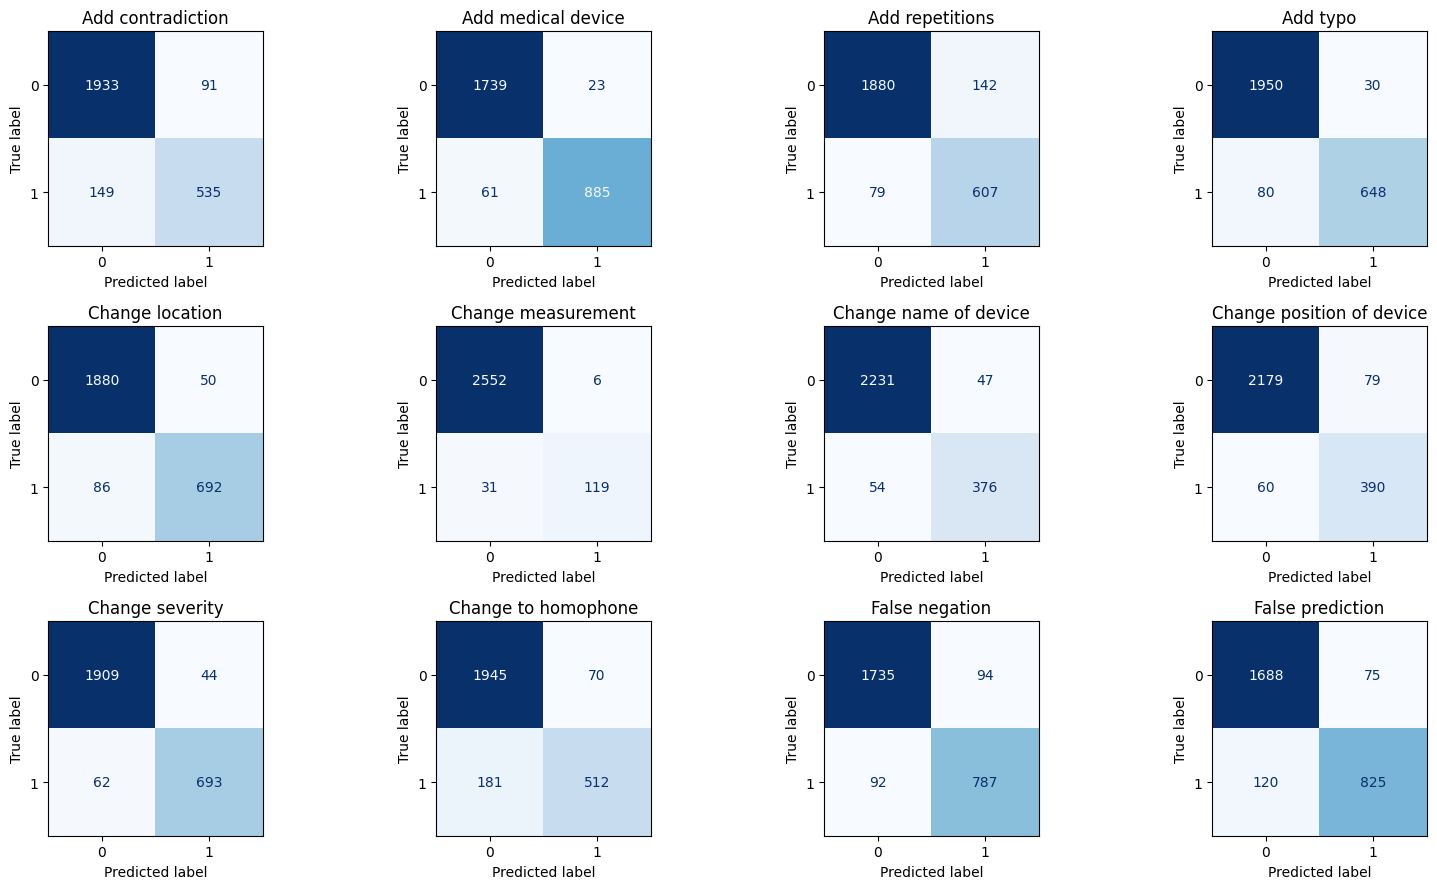

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm_all_cl = multilabel_confusion_matrix(true_labels_np_cl, preds_cl)

n_rows = 3
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(cm_all_cl, labels_name)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"0", "1"])
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

# Ensemble


In [ ]:
X_meta = np.concatenate([probs_val, probs_bcl_val], axis=1)
y_meta = tokenized_dataset_val['labels']

meta_model = MultiOutputClassifier(MLPClassifier(verbose=True))
meta_model.fit(X_meta, y_meta)

Iteration 1, loss = 0.68029876
Iteration 2, loss = 0.56788114
Iteration 3, loss = 0.49076069
Iteration 4, loss = 0.43665077
Iteration 5, loss = 0.39143249
Iteration 6, loss = 0.35047704
Iteration 7, loss = 0.31433832
Iteration 8, loss = 0.28405393
Iteration 9, loss = 0.25945710
Iteration 10, loss = 0.24027267
Iteration 11, loss = 0.22645391
Iteration 12, loss = 0.21580166
Iteration 13, loss = 0.20881424
Iteration 14, loss = 0.20375922
Iteration 15, loss = 0.20010975
Iteration 16, loss = 0.19778243
Iteration 17, loss = 0.19660157
Iteration 18, loss = 0.19502144
Iteration 19, loss = 0.19318612
Iteration 20, loss = 0.19205876
Iteration 21, loss = 0.19126272
Iteration 22, loss = 0.19096502
Iteration 23, loss = 0.19051760
Iteration 24, loss = 0.18974061
Iteration 25, loss = 0.18920797
Iteration 26, loss = 0.18894150
Iteration 27, loss = 0.18841285
Iteration 28, loss = 0.18894034
Iteration 29, loss = 0.18790592
Iteration 30, loss = 0.18716599
Iteration 31, loss = 0.18745985
Iteration 32, los

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 17, loss = 0.09139937
Iteration 18, loss = 0.08910297
Iteration 19, loss = 0.08725001
Iteration 20, loss = 0.08588738
Iteration 21, loss = 0.08464148
Iteration 22, loss = 0.08376870
Iteration 23, loss = 0.08295063
Iteration 24, loss = 0.08242937
Iteration 25, loss = 0.08180907
Iteration 26, loss = 0.08118347
Iteration 27, loss = 0.08074070
Iteration 28, loss = 0.08022180
Iteration 29, loss = 0.07986466
Iteration 30, loss = 0.07944599
Iteration 31, loss = 0.07896436
Iteration 32, loss = 0.07894008
Iteration 33, loss = 0.07864706
Iteration 34, loss = 0.07826935
Iteration 35, loss = 0.07790726
Iteration 36, loss = 0.07779869
Iteration 37, loss = 0.07783277
Iteration 38, loss = 0.07736297
Iteration 39, loss = 0.07717544
Iteration 40, loss = 0.07710909
Iteration 41, loss = 0.07676880
Iteration 42, loss = 0.07650658
Iteration 43, loss = 0.07686178
Iteration 44, loss = 0.07705223
Iteration 45, loss = 0.07629121
Iteration 46, loss = 0.07620140
Iteration 47, loss = 0.07594633
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 36, loss = 0.14751958
Iteration 37, loss = 0.14723286
Iteration 38, loss = 0.14687981
Iteration 39, loss = 0.14687893
Iteration 40, loss = 0.14654495
Iteration 41, loss = 0.14622275
Iteration 42, loss = 0.14616002
Iteration 43, loss = 0.14597250
Iteration 44, loss = 0.14573537
Iteration 45, loss = 0.14604090
Iteration 46, loss = 0.14551038
Iteration 47, loss = 0.14515497
Iteration 48, loss = 0.14522585
Iteration 49, loss = 0.14490114
Iteration 50, loss = 0.14499613
Iteration 51, loss = 0.14472423
Iteration 52, loss = 0.14431881
Iteration 53, loss = 0.14432013
Iteration 54, loss = 0.14430004
Iteration 55, loss = 0.14445805
Iteration 56, loss = 0.14373036
Iteration 57, loss = 0.14364528
Iteration 58, loss = 0.14354957
Iteration 59, loss = 0.14342044
Iteration 60, loss = 0.14386984
Iteration 61, loss = 0.14294103
Iteration 62, loss = 0.14296117
Iteration 63, loss = 0.14268018
Iteration 64, loss = 0.14267283
Iteration 65, loss = 0.14300882
Iteration 66, loss = 0.14260002
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.16575187
Iteration 20, loss = 0.16421549
Iteration 21, loss = 0.16291974
Iteration 22, loss = 0.16211489
Iteration 23, loss = 0.16124422
Iteration 24, loss = 0.16049754
Iteration 25, loss = 0.15974186
Iteration 26, loss = 0.15944298
Iteration 27, loss = 0.15846543
Iteration 28, loss = 0.15852269
Iteration 29, loss = 0.15813681
Iteration 30, loss = 0.15843054
Iteration 31, loss = 0.15776105
Iteration 32, loss = 0.15720122
Iteration 33, loss = 0.15700549
Iteration 34, loss = 0.15699454
Iteration 35, loss = 0.15673214
Iteration 36, loss = 0.15651916
Iteration 37, loss = 0.15729878
Iteration 38, loss = 0.15698800
Iteration 39, loss = 0.15588963
Iteration 40, loss = 0.15582561
Iteration 41, loss = 0.15576169
Iteration 42, loss = 0.15503905
Iteration 43, loss = 0.15521537
Iteration 44, loss = 0.15517331
Iteration 45, loss = 0.15488361
Iteration 46, loss = 0.15476118
Iteration 47, loss = 0.15457981
Iteration 48, loss = 0.15459099
Iteration 49, loss = 0.15466026
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 32, loss = 0.10675392
Iteration 33, loss = 0.10643000
Iteration 34, loss = 0.10629415
Iteration 35, loss = 0.10575873
Iteration 36, loss = 0.10550984
Iteration 37, loss = 0.10511397
Iteration 38, loss = 0.10493529
Iteration 39, loss = 0.10455688
Iteration 40, loss = 0.10460584
Iteration 41, loss = 0.10412547
Iteration 42, loss = 0.10376118
Iteration 43, loss = 0.10345691
Iteration 44, loss = 0.10319385
Iteration 45, loss = 0.10330462
Iteration 46, loss = 0.10307847
Iteration 47, loss = 0.10280414
Iteration 48, loss = 0.10254314
Iteration 49, loss = 0.10223642
Iteration 50, loss = 0.10204695
Iteration 51, loss = 0.10182809
Iteration 52, loss = 0.10162939
Iteration 53, loss = 0.10172824
Iteration 54, loss = 0.10147211
Iteration 55, loss = 0.10134429
Iteration 56, loss = 0.10110879
Iteration 57, loss = 0.10084003
Iteration 58, loss = 0.10073949
Iteration 59, loss = 0.10045075
Iteration 60, loss = 0.10079186
Iteration 61, loss = 0.10035360
Iteration 62, loss = 0.09982545
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.05515460
Iteration 16, loss = 0.05019753
Iteration 17, loss = 0.04620805
Iteration 18, loss = 0.04283968
Iteration 19, loss = 0.04022432
Iteration 20, loss = 0.03799482
Iteration 21, loss = 0.03631388
Iteration 22, loss = 0.03487079
Iteration 23, loss = 0.03362592
Iteration 24, loss = 0.03261586
Iteration 25, loss = 0.03177170
Iteration 26, loss = 0.03101106
Iteration 27, loss = 0.03037674
Iteration 28, loss = 0.02987176
Iteration 29, loss = 0.02933554
Iteration 30, loss = 0.02880957
Iteration 31, loss = 0.02835512
Iteration 32, loss = 0.02806773
Iteration 33, loss = 0.02778096
Iteration 34, loss = 0.02745459
Iteration 35, loss = 0.02717517
Iteration 36, loss = 0.02699486
Iteration 37, loss = 0.02678217
Iteration 38, loss = 0.02658024
Iteration 39, loss = 0.02636394
Iteration 40, loss = 0.02613277
Iteration 41, loss = 0.02613099
Iteration 42, loss = 0.02592808
Iteration 43, loss = 0.02573923
Iteration 44, loss = 0.02555628
Iteration 45, loss = 0.02545996
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.56161306
Iteration 2, loss = 0.44195421
Iteration 3, loss = 0.36263066
Iteration 4, loss = 0.31165029
Iteration 5, loss = 0.27665985
Iteration 6, loss = 0.24789292
Iteration 7, loss = 0.22227387
Iteration 8, loss = 0.19801985
Iteration 9, loss = 0.17764826
Iteration 10, loss = 0.16035873
Iteration 11, loss = 0.14649870
Iteration 12, loss = 0.13565947
Iteration 13, loss = 0.12747631
Iteration 14, loss = 0.12142086
Iteration 15, loss = 0.11692436
Iteration 16, loss = 0.11349027
Iteration 17, loss = 0.11122089
Iteration 18, loss = 0.10922740
Iteration 19, loss = 0.10787317
Iteration 20, loss = 0.10665825
Iteration 21, loss = 0.10574820
Iteration 22, loss = 0.10497032
Iteration 23, loss = 0.10408272
Iteration 24, loss = 0.10394051
Iteration 25, loss = 0.10326837
Iteration 26, loss = 0.10243971
Iteration 27, loss = 0.10219479
Iteration 28, loss = 0.10194100
Iteration 29, loss = 0.10157943
Iteration 30, loss = 0.10103336
Iteration 31, loss = 0.10067588
Iteration 32, los

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 23, loss = 0.08381994
Iteration 24, loss = 0.08307398
Iteration 25, loss = 0.08242856
Iteration 26, loss = 0.08188617
Iteration 27, loss = 0.08148035
Iteration 28, loss = 0.08114659
Iteration 29, loss = 0.08070868
Iteration 30, loss = 0.08056582
Iteration 31, loss = 0.07992045
Iteration 32, loss = 0.07972907
Iteration 33, loss = 0.07942968
Iteration 34, loss = 0.07923327
Iteration 35, loss = 0.07908766
Iteration 36, loss = 0.07891629
Iteration 37, loss = 0.07852205
Iteration 38, loss = 0.07839353
Iteration 39, loss = 0.07827185
Iteration 40, loss = 0.07811118
Iteration 41, loss = 0.07790857
Iteration 42, loss = 0.07771292
Iteration 43, loss = 0.07752673
Iteration 44, loss = 0.07733975
Iteration 45, loss = 0.07724925
Iteration 46, loss = 0.07708178
Iteration 47, loss = 0.07699606
Iteration 48, loss = 0.07679354
Iteration 49, loss = 0.07660457
Iteration 50, loss = 0.07647491
Iteration 51, loss = 0.07641713
Iteration 52, loss = 0.07636035
Iteration 53, loss = 0.07617182
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.27124250
Iteration 13, loss = 0.26085123
Iteration 14, loss = 0.25364695
Iteration 15, loss = 0.24950169
Iteration 16, loss = 0.24643560
Iteration 17, loss = 0.24416193
Iteration 18, loss = 0.24236428
Iteration 19, loss = 0.24124614
Iteration 20, loss = 0.24044735
Iteration 21, loss = 0.23922028
Iteration 22, loss = 0.23911817
Iteration 23, loss = 0.23838615
Iteration 24, loss = 0.23774662
Iteration 25, loss = 0.23736737
Iteration 26, loss = 0.23689184
Iteration 27, loss = 0.23700025
Iteration 28, loss = 0.23651223
Iteration 29, loss = 0.23610100
Iteration 30, loss = 0.23607229
Iteration 31, loss = 0.23571976
Iteration 32, loss = 0.23583357
Iteration 33, loss = 0.23494011
Iteration 34, loss = 0.23472709
Iteration 35, loss = 0.23467468
Iteration 36, loss = 0.23416404
Iteration 37, loss = 0.23395365
Iteration 38, loss = 0.23367728
Iteration 39, loss = 0.23338841
Iteration 40, loss = 0.23323705
Iteration 41, loss = 0.23301109
Iteration 42, loss = 0.23298986
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 32, loss = 0.15229253
Iteration 33, loss = 0.15228739
Iteration 34, loss = 0.15167125
Iteration 35, loss = 0.15141440
Iteration 36, loss = 0.15075470
Iteration 37, loss = 0.15048335
Iteration 38, loss = 0.15020239
Iteration 39, loss = 0.14968924
Iteration 40, loss = 0.14942677
Iteration 41, loss = 0.14907936
Iteration 42, loss = 0.14866874
Iteration 43, loss = 0.14865289
Iteration 44, loss = 0.14849797
Iteration 45, loss = 0.14820133
Iteration 46, loss = 0.14786169
Iteration 47, loss = 0.14763999
Iteration 48, loss = 0.14711300
Iteration 49, loss = 0.14688844
Iteration 50, loss = 0.14671830
Iteration 51, loss = 0.14648824
Iteration 52, loss = 0.14607280
Iteration 53, loss = 0.14609169
Iteration 54, loss = 0.14611478
Iteration 55, loss = 0.14554779
Iteration 56, loss = 0.14531321
Iteration 57, loss = 0.14492116
Iteration 58, loss = 0.14462536
Iteration 59, loss = 0.14432344
Iteration 60, loss = 0.14428955
Iteration 61, loss = 0.14399483
Iteration 62, loss = 0.14406499
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.18608463
Iteration 17, loss = 0.18309056
Iteration 18, loss = 0.18085891
Iteration 19, loss = 0.17885008
Iteration 20, loss = 0.17721445
Iteration 21, loss = 0.17588207
Iteration 22, loss = 0.17485702
Iteration 23, loss = 0.17402650
Iteration 24, loss = 0.17285475
Iteration 25, loss = 0.17215407
Iteration 26, loss = 0.17156706
Iteration 27, loss = 0.17077547
Iteration 28, loss = 0.17067163
Iteration 29, loss = 0.16981338
Iteration 30, loss = 0.16954104
Iteration 31, loss = 0.16889130
Iteration 32, loss = 0.16837379
Iteration 33, loss = 0.16784628
Iteration 34, loss = 0.16754147
Iteration 35, loss = 0.16726112
Iteration 36, loss = 0.16726273
Iteration 37, loss = 0.16669348
Iteration 38, loss = 0.16603322
Iteration 39, loss = 0.16584038
Iteration 40, loss = 0.16551047
Iteration 41, loss = 0.16511928
Iteration 42, loss = 0.16481378
Iteration 43, loss = 0.16437241
Iteration 44, loss = 0.16421432
Iteration 45, loss = 0.16372485
Iteration 46, loss = 0.16329320
Iteratio

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MultiOutputClassifier(estimator=MLPClassifier(verbose=True))

In [ ]:
X_test = np.concatenate([probs, probs_bcl], axis=1)
meta_preds = meta_model.predict(X_test)

In [ ]:
print("f1_micro:", f1_score(tokenized_dataset_test_cl['labels'], meta_preds, average="micro"))
print("f1_macro:", f1_score(tokenized_dataset_test_cl['labels'], meta_preds, average="macro"))
print("precision:", precision_score(tokenized_dataset_test_cl['labels'], meta_preds, average="micro"))
print("recall:", recall_score(tokenized_dataset_test_cl['labels'], meta_preds, average="micro"))

f1_micro: 0.8930244176606508
f1_macro: 0.8901955958117065
precision: 0.9063252630244645
recall: 0.8801083210241261


In [ ]:
loss_meta = hamming_loss(tokenized_dataset_test_cl['labels'], meta_preds)
loss_meta

0.052714180206794685

In [ ]:
true_labels_np_meta = np.array(tokenized_dataset_test_cl['labels'])
false_negatives_meta = np.logical_and(true_labels_np_meta == 1, meta_preds == 0)
false_positives_meta = np.logical_and(true_labels_np_meta == 0, meta_preds == 1)

fn_counts_meta = np.sum(false_negatives_meta, axis=0)
fp_counts_meta = np.sum(false_positives_meta, axis=0)

total_errors_meta = fn_counts_meta + fp_counts_meta

for i in np.argsort(-total_errors_meta):
    print(f"{labels_name[i]}: {total_errors_meta[i]} errors (FN: {fn_counts_meta[i]}, FP: {fp_counts_meta[i]})")

Change to homophone: 253 errors (FN: 163, FP: 90)
Add contradiction: 224 errors (FN: 124, FP: 100)
False prediction: 198 errors (FN: 90, FP: 108)
False negation: 193 errors (FN: 117, FP: 76)
Add repetitions: 188 errors (FN: 97, FP: 91)
Change position of device: 140 errors (FN: 63, FP: 77)
Add typo: 122 errors (FN: 71, FP: 51)
Change location: 110 errors (FN: 52, FP: 58)
Add medical device: 93 errors (FN: 67, FP: 26)
Change name of device: 83 errors (FN: 63, FP: 20)
Change severity: 83 errors (FN: 51, FP: 32)
Change measurement: 26 errors (FN: 16, FP: 10)


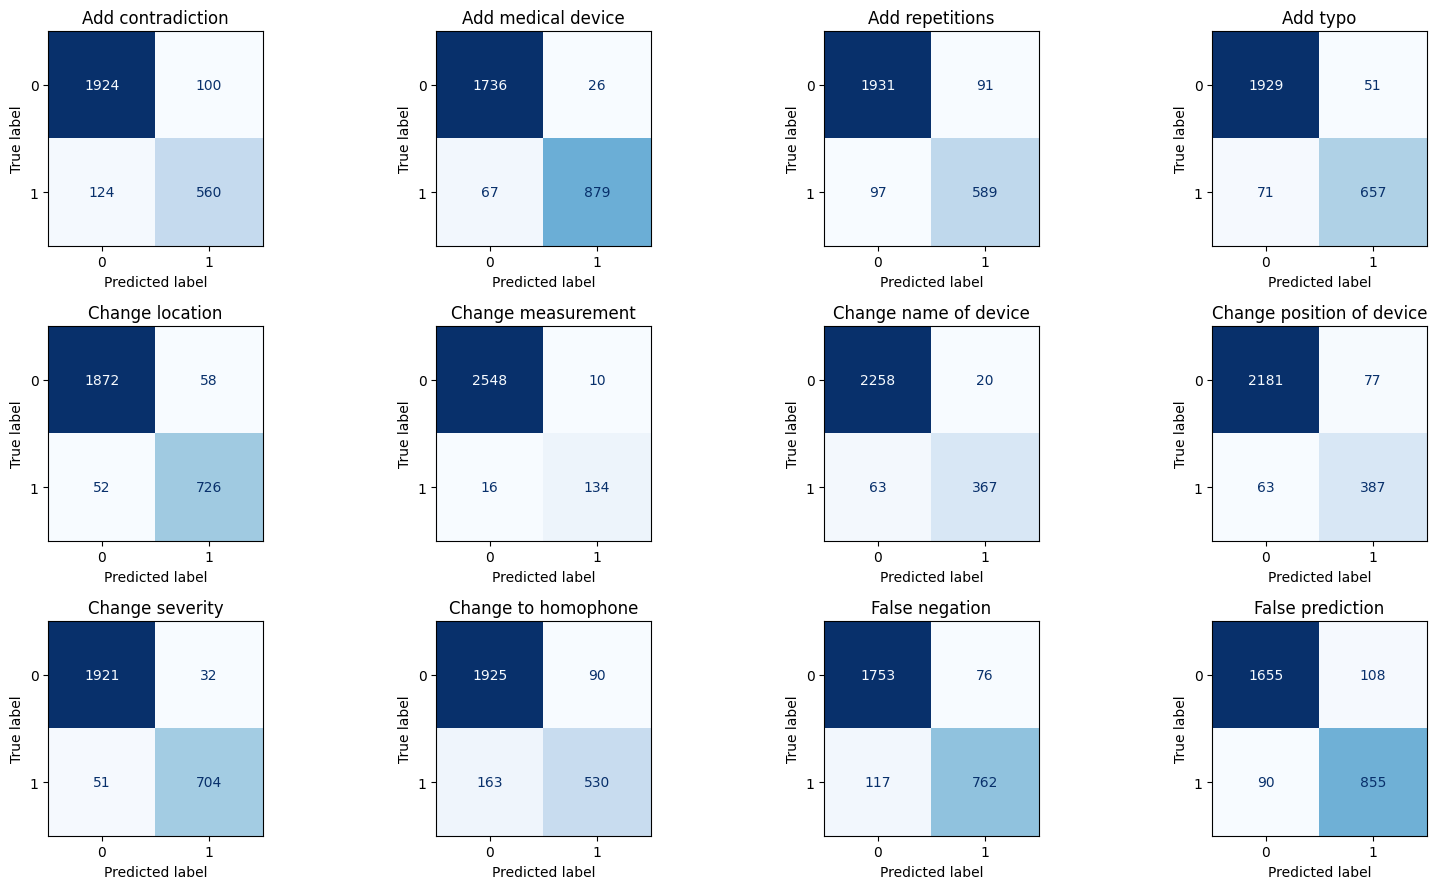

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm_all_meta = multilabel_confusion_matrix(true_labels_np_cl, meta_preds)

n_rows = 3
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(cm_all_meta, labels_name)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"0", "1"])
    disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False)
    axes[i].set_title(label)

plt.tight_layout()
plt.show()